In [7]:
import numpy
from math import pi
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

from laplace_helper import plot_3D, L2_rel_error
from cg_helper import poisson_2d, p_analytical

In [13]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

x= numpy.linspace(xmin, xmax, nx)
y = numpy.linspace(ymin, ymax, ny)
X,Y = numpy.meshgrid(x,y)

#Source
u = 1
b = u*numpy.ones_like(X);

#Initialization
psi_i = numpy.zeros((ny, nx))
w_i = numpy.zeros((ny, nx))

In [3]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [5]:
def conjugate_gradient_2d(p, b, dx, dy, l1_target):
    '''Performs Conjugate Gradient relaxation
        Assumes Dirichlet boundary conditions p=0
        
        Parameters:
            p- intial guess
            b- source term
            dx- mesh spacing in x
            dy- mesh spacing in y
            l2_target- exit criteria
            
        Returns:
            p- distribution after relaxation
    '''
    
    ny, nx = p.shape
    r = numpy.zeros((ny, nx))
    Ad = numpy.zeros((ny, nx))
    
    l1_norm = 1
    iterations = 0
    l1_conv = []
    
    #compute intial residual, which we will use for the first direction 
    r[1:-1, 1:-1] = b[1:-1, 1:-1]*dx**2 + 4*p[1:-1,1:-1] - \
        p[1:-1,2:] - p[1:-1,:-2] - p[2:,1:-1] - p[:-2,1:-1]
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad[1:-1,1:-1] = -4*d[1:-1,1:-1]+d[1:-1,2:]+d[1:-1,:-2] + \
        d[2:,1:-1] + d[:-2,1:-1]
    sigma = numpy.sum(d*Ad)
    
    #Iterations
    while l1_norm > l1_target:
        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        alpha = rho/sigma
        
        p = pk + alpha*dk
        r = rk - alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[1:-1, 1:-1] = -4*d[1:-1,1:-1] + d[1:-1,2:] + d[1:-1,:-2] + \
            d[2:,1:-1] + d[:-2, 1:-1]
        sigma = numpy.sum(d*Ad)
        
        #Enforce BCs
        #w[j,i]
        w[]
        for j in range(2, ny+1):
            w
        
        
        l1_norm = min(L1_norm(psik,psi), L1_norm(wk, w))
        iterations += 1
        l1_conv.append(l1_norm)
        
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l1_conv

In [ ]:
p, l1_conv = conjugate_gradient_2d(p, b, dx, dy, l1_target)

3

NameError: name 'p' is not defined

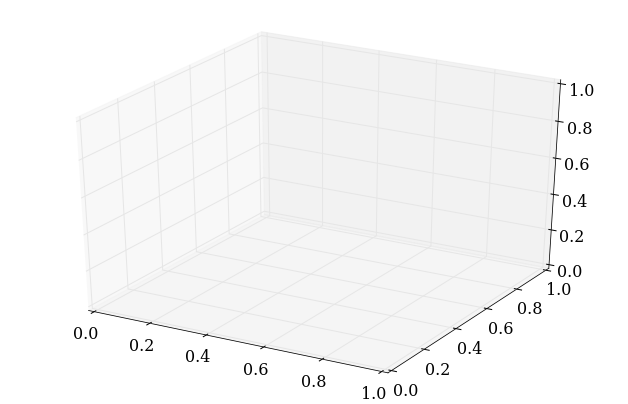

In [11]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
ax = fig.gca(projection='3d')
#ax = fig.gca()
X,Y = numpy.meshgrid(x,y)
surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)



ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.view_init(30,45)